In [0]:
# TO download data from Kaggle uncomment this. 

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# ! kaggle competitions download -c word2vec-nlp-tutorial

In [0]:
# you should be using the tensorflow 2 version
!pip install tensorflow==2.0.0-beta0
import tensorflow as tf
print(tf.__version__)


     |████████████████████████████████| 87.9MB 113kB/s 
     |████████████████████████████████| 3.1MB 34.1MB/s 
     |████████████████████████████████| 501kB 50.7MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta0


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from bs4 import BeautifulSoup
from nltk import word_tokenize
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

embedding_dim = 100
max_length = 120
trunc_type='pre' #usually the final impression is by the end
padding_type='pre'
oov_tok = "<OOV>"
training_size=75000
test_portion=.2

corpus = []

In [0]:
#get additional sentences from imdb dataset from keras.datasets
import keras
NUM_WORDS=10000 # only use top 1000 words
INDEX_FROM=3 

train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
train_x,train_y = train
test_x,test_y = test

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
# print(' '.join(id_to_word[id] for id in train_x[0] ))
# print(' '.join(id_to_word[id] for id in test_x[6] ))
additional = train_x.tolist()
additional = additional + test_x.tolist()
additional_labels = train_y.tolist() + test_y.tolist()
len(additional) == len( additional_labels)


True

In [0]:
# To remove the word "<START>" from the beggining of sentences
additional_sentences= []
for i in range(len(additional)):
  senten = (' '.join(id_to_word[id] for id in additional[i] )).replace("<START>", "")
  
  additional_sentences.append(senten)
print(additional_sentences[0] )

 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they 

In [0]:
# uploading our initial data
train_label = pd.read_csv("labeledTrainData.tsv", sep='\t',index_col=0)
#train_unlabel = pd.read_csv("unlabeledTrainData.tsv", sep='\t',index_col=0)
test = pd.read_csv("testData.tsv", sep='\t',index_col=0)
labels = train_label["sentiment"].values.tolist()
review_str = train_label["review"].values.tolist()

In [0]:
train_label.head()

,sentiment,review
id,,
5814_8,1,With all this stuff going down at the moment w...
2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
7759_3,0,The film starts with a manager (Nicholas Bell)...
3630_4,0,It must be assumed that those who praised this...
9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [0]:
total_x = review_str + additional_sentences
total_y = np.array( labels + additional_labels) 
len( total_x ) == len(total_y)

True

In [0]:
#example
review_str[15:16]

['Stephen King adaptation (scripted by King himself) in which a young family, newcomers to rural Maine, find out about the pet cemetery close to their home. The father (Dale Midkiff) then finds out about the Micmac burial ground beyond the pet cemetery that has powers of resurrection - only of course anything buried there comes back not quite RIGHT.<br /><br />Below average \\horror\\" picture starts out clumsy, insulting, and inept, and continues that way for a while, with the absolute worst element being Midkiff\'s worthless performance. It gets a little better toward the end, with genuinely disturbing finale. In point of fact, the whole movie is really disturbing, which is why I can\'t completely dismiss it - at least it has SOMETHING to make it memorable. Decent supporting performances by Fred Gwynne, as the wise old aged neighbor, and Brad Greenquist, as the disfigured spirit Victor Pascow are not enough to really redeem film.<br /><br />King has his usual cameo as the minister.<b

In [0]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    #6.Lemmatization
    for word in meaningful_words:
        word = lemmatizer.lemmatize(word,'v')
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [0]:
sentences_cleaned = []
i = 0
for sentence in total_x:
  sentence = review_to_words( sentence )
  sentences_cleaned.append(sentence)

In [0]:
# to see the difference between cleaned and uncleaned text
sentences_cleaned[0]


'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [0]:
total_x[0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [0]:
tokenizer = Tokenizer( oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_cleaned)
word_index = tokenizer.word_index
vocab_size=len(word_index)


sequences = tokenizer.texts_to_sequences(sentences_cleaned)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = total_y[0:split]
training_labels = total_y[split:]

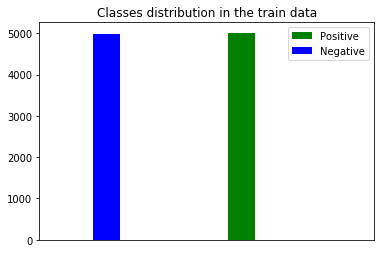

In [0]:
#Check data balance
import matplotlib.pyplot as plt

pos = [1 for i in range( len(training_labels)) if training_labels[i] == 1]
neg = [0 for i in range( len(training_labels)) if training_labels[i] == 0]
bins = np.linspace(-10, 10, 100)
plt.hist(pos,
         bins= bins, color='green', label='Positive')
plt.hist(neg,
         bins=bins, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [0]:
print( "len( padded[5]) == len( sequences [5]):" , len( padded[5]) == len( sequences [5]))
# should be False

In [0]:
#Note this is the 100 dimension version of GloVe from Stanford

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-10-31 13:34:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  56.9MB/s    in 5.8s    

2019-10-31 13:34:24 (56.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          7406700   
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 7,504,941
Trainable params: 98,241
Non-trainable params: 7,406,700
_________________________________________

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
num_epochs = 50
batch_size = 512
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
# check point 
mc = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', verbose=1)
# fit and evaluate the model
history = model.fit(training_sequences, training_labels, batch_size = batch_size, epochs=num_epochs,  validation_data=(test_sequences, test_labels), verbose=2,callbacks=[es, mc])

print("Training Complete")

Train on 60000 samples, validate on 15000 samples
Epoch 1/50

Epoch 00001: saving model to best_model1.h5
60000/60000 - 72s - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.3808 - val_accuracy: 0.9092
Epoch 2/50

Epoch 00002: saving model to best_model1.h5
60000/60000 - 70s - loss: 0.0714 - accuracy: 0.9741 - val_loss: 0.3305 - val_accuracy: 0.9047
Epoch 3/50

Epoch 00003: saving model to best_model1.h5
60000/60000 - 70s - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.3749 - val_accuracy: 0.9051
Epoch 4/50

Epoch 00004: saving model to best_model1.h5
60000/60000 - 72s - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.4887 - val_accuracy: 0.8971
Epoch 5/50

Epoch 00005: saving model to best_model1.h5
60000/60000 - 72s - loss: 0.0609 - accuracy: 0.9768 - val_loss: 0.3720 - val_accuracy: 0.9117
Epoch 6/50

Epoch 00006: saving model to best_model1.h5
60000/60000 - 72s - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.3851 - val_accuracy: 0.9114
Epoch 7/50

Epoch 00007: saving model to best_mode

In [0]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [0]:
from keras.models import load_model
model.load_weights('best_model1.h5')


<Figure size 432x288 with 0 Axes>

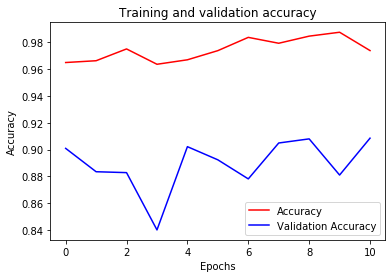

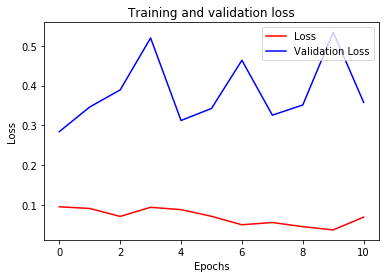

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [0]:
test = pd.read_csv("testData.tsv", sep='\t')
test_str = test["review"].values.tolist()

test_sequences_sub = tokenizer.texts_to_sequences(test_str)
test_padded = pad_sequences(test_sequences_sub, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
predictions = model.predict( test_padded)

In [0]:
pred_int =  (( predictions > 0.9 ) * 1 ).tolist()
pred_int = [i[0] for i in pred_int]
test['sentiment'] =  pred_int
test.to_csv('submission_final2.csv', index=False, columns=['id','sentiment'])